# Hydrology of World Cities

By Andrew Ireson(1) and Simon Mathias(2)

1. Global Institute for Water Security, University of Saskatchewan, Canada
2. University of Durham, UK

## Usage

Run every block of code to import libraries and load functions. To modify cities, edit the block of code below the title "Run the Script:". 

In [1]:
import matplotlib.pyplot as pl
import numpy as np
import HWC

## Run the script:

Call HWC.GetCityData as many times as needed to get city data.

In [2]:
saskatoon=HWC.GetCityData('Saskatoon','')
london=HWC.GetCityData('London','United')

Saskatoon, Saskatchewan - Canada
Lat: 52.170000, Lon: -106.680000, Alt: 499.779755
London - United Kingdom of Great Britain and Northern Ireland
Lat: 51.504722, Lon: -0.131111, Alt: 4.546525


In [3]:
HWC.PrintCityData(saskatoon)

   R (mm), PE (mm)
J, 15.2,   7.6
F, 10.3,   12.0
M, 14.7,   27.9
A, 23.9,   66.3
M, 49.4,   113.6
J, 61.1,   132.3
J, 60.1,   142.0
A, 38.8,   122.9
S, 30.7,   73.5
O, 16.7,   39.5
N, 13.3,   12.9
D, 15.9,   7.8


In [4]:
HWC.PrintCityData(london)

   R (mm), PE (mm)
J, 41.6,   13.5
F, 36.3,   20.0
M, 40.3,   40.1
A, 40.1,   65.6
M, 44.9,   94.2
J, 47.4,   107.6
J, 34.6,   117.7
A, 54.3,   98.8
S, 51.0,   64.3
O, 61.1,   35.1
N, 57.5,   17.3
D, 48.4,   12.0


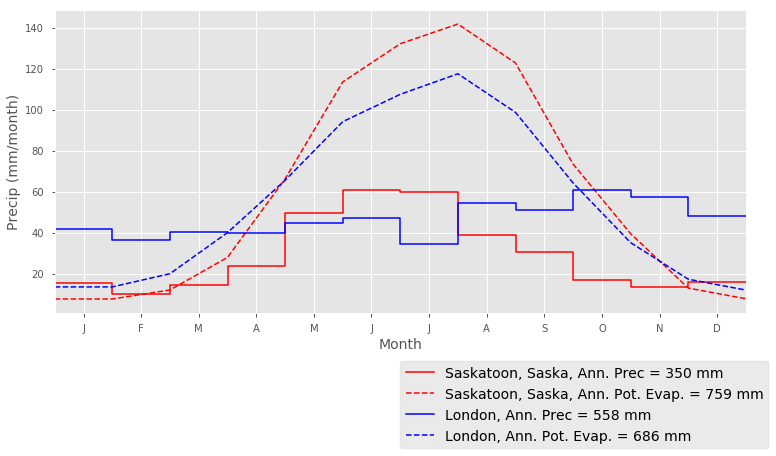

In [5]:
HWC.PlotP_PE([saskatoon,london],'rb')

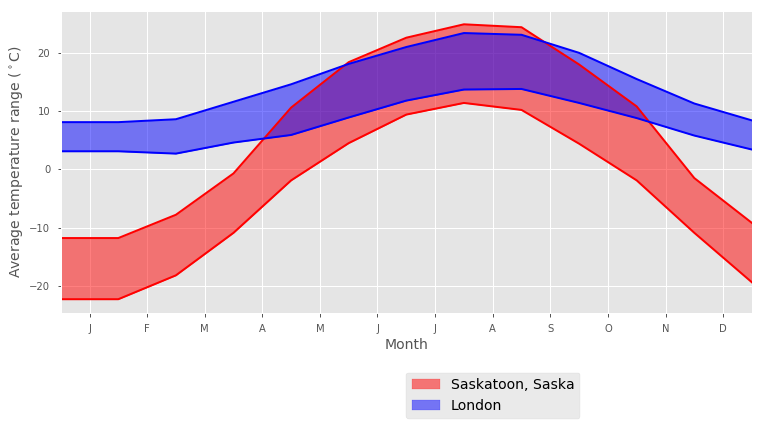

In [6]:
HWC.PlotT([saskatoon,london],'rb')

# Optional: plot map

You can also plot a world map showing the city location. Since this requires you to install the basemap package, which is a bit awkward, this part is optional. 

I was able to install basemap on my system, which is using the anaconda distribution of python v3.7, using the following commands:

```
conda install -c conda-forge proj4
conda install -c conda-forge basemap
conda install -c conda-forge geopy
conda update -n base conda
```

In [7]:
import HWC_maps

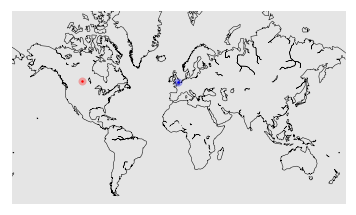

In [8]:
HWC_maps.PlotMap([saskatoon,london])